# Adult Census - Income Prediction Using ML

This is my first data science project. I will analyze the adult census data extracted from the 1994 Census Bereau database by Ronny Kohavi and Barry Becker (https://www.kaggle.com/uciml/adult-census-income). This dataset looks at several variables to predict whether a person had an annual income over $50k. I will perform the following on this dataset:
- check for missing data and either 1) remove rows/columns containing missing data or 2) impute missing values
- merge related categories to reduce feature size
- scale numeric data and one-hot-encode categorical data
- test K-Nearest Neighbors (KNN) model with a gridsearchCV to optimize the model
- test support vector machines (SVM) if the KNN model is inaccurate
- evaluate and visualize the final model

In [97]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [98]:
# directory for the dataset on my computer
filename = 'datasets/adult.csv'
adult_df = pd.read_csv(filename)

I will visually inspect the first few rows of the data frame.

In [99]:
adult_df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


The missing values in this dataset are all represented as '?' so I will replace with NaN.

In [100]:
adult_df.where(adult_df!='?',other=np.nan,inplace=True)

There are 1836 rows missing more than one value.  This is a tiny fraction of the total data so I will remove these values.

In [101]:
# Remove Samples with multiple NaN values
mask = adult_df.isnull().sum(axis=1) > 1
print(mask.sum()) # 1836 samples
idx = np.where(mask==True)[0]
idx = adult_df.index[idx]
adult_df.drop(index=idx,inplace=True)

1836


While inspecting the data, I identified 7 rows where the occupation is NaN, but for these rows, workclass = never-worked, which means that these people do not have a job and do not have an income. Therefore, there is no point in using these samples in the model, so I will remove these rows.

In [102]:
# 7 people with occupation = NaN do not have a job (workclass = Never-worked) so will drop these
mask = adult_df.occupation.isnull()
idx = np.where(mask==True)[0]
idx = adult_df.index[idx]
adult_df.drop(index=idx,inplace=True)

The biggest chunk of missing data is in the native country column.  There are multiple methods to remove the missing data as shown below.  Ultimately, I decided that there are too many countries to consider, so it is better to consider just domestic vs. foreign.  The overwhelming majority of rows are domestic so I imputed the missing data as domestic.

In [103]:
# Hundreds of people with unknown native country - multiple options to try

# delete samples from dataset
def delete_country_Nan():
    mask = adult_df['native.country'].isnull()
    idx = np.where(mask==True)[0]
    idx = adult_df.index[idx]
    adult_df.drop(index=idx,inplace=True)

# try most common value: United-States
def country_NaN_USA():
    mask = adult_df['native.country'].isnull()
    adult_df['native.country'] = np.where(mask,'United-States',adult_df['native.country'])

# convert native.country variable to domestic vs. foreign
# guess determines whether NaN values should be converted to domestic or foreign (guess = 'United-States' vs. 'foreign')
def country_DvF(guess):
    mask_null = adult_df['native.country'].isnull()
    adult_df['native.country'] = np.where(mask_null,guess,adult_df['native.country'])
    
    mask = adult_df['native.country'] == 'United-States'
    adult_df['native.country'] = np.where(mask,'domestic','foreign')
    
guess = 'United-States'
country_DvF(guess)

## Feature Descriptions
Below is a list of the features with a description to determine how each column should be modified.
- Age: numeric
- workclass: categorical with 7 categories
- fnlwgt: numeric
- education: categorical with 16 categories (need to reduce)
- education.num: numeric (potentially redundant with education but can leave it anyway)
- marital.status: categorical with 7 categories (need to reduce)
- occupation: categorical with 14 categories (This is potentially the most important feature so need stratification of test-train split)
- relationship: categorical with 7 categories (redundant with marital.status so should delete)
- race: categorical with 5 categories
- sex: categorical with 2 categories
- capital.gain: numeric (highly skewed so should be converted to category)
- capital.loss: numeric (highly skewed so should be converted to category)
- hours.per.week: numeric
- native.country: categorical (converted to domestic vs. foreign)
- income: categorical with 2 categories

## Data Modification
Below is a list of how I will modify the data
- Age: N/A
- Workclass: drop 14 samples with "without-pay" since there are few samples and this obviously leads to low income
- fnlwgt: N/A
- education: merge into: 
    - Less than HS-grad (many of these are likely to lead to similar outcomes)
    - HS-grad + some college (likely little difference between these)
    - Assoc voc+adm (likely little difference between these)
    - Bachelors
    - Masters
    - Doctorate
    - Prof-school
- education.num: N/A
- marital.status: merge into:
    - civ + absent + AF (likely little difference between these)
    - never-married
    - divorced + separated (likely little difference between these)
    - widowed
- occupation: N/A
- relationship: delete (too similar to marital.status)
- race: N/A
- sex: N/A
- capital.gain: merge into categories:
    - 0
    - (>0 and < 10000)
    - (> 10000)
- capital.oss: merge into categories:
    - 0
    - (>0)
- hours.per.week: N/A
- native.country: make domestic vs. foreign
- income: N/A

In [104]:
# drop workclass = without-pay
def drop_withoutpay(adult_df):
    mask = adult_df.workclass == 'Without-pay'
    idx = np.where(mask==True)[0]
    idx = adult_df.index[idx]
    adult_df.drop(index=idx,inplace=True)

# Merge education categories: ('HS','Assoc','Less_HS','Bachelors','Masters','Prof-School','Doctorate')
def merge_education(adult_df):
    mask1 = adult_df.education == 'HS-grad'
    mask2 = adult_df.education == 'Some-college'
    
    mask3 = adult_df.education == 'Assoc-voc'
    mask4 = adult_df.education == 'Assoc-acdm'
    
    mask5 = adult_df.education == '11th'
    mask6 = adult_df.education == '10th'
    mask7 = adult_df.education == '7th-8th'
    mask8 = adult_df.education == '9th'
    mask9 = adult_df.education == '12th'
    mask10 = adult_df.education == '5th-6th'
    mask11 = adult_df.education == '1st-4th'
    mask12 = adult_df.education == 'Preschool'
    
    adult_df.education = np.where(mask1|mask2,'HS',adult_df.education)
    adult_df.education = np.where(mask3|mask4,'Assoc',adult_df.education)
    adult_df.education = np.where(mask5|mask6|mask7|mask8|mask9|mask10|mask11|mask12,'Less_HS',adult_df.education)
    
# Merge marital status: ('Married','Never-married','Sep_Div','Widowed')
def merge_marital(adult_df):
    mask1 = adult_df['marital.status'] == 'Married-civ-spouse'
    mask2 = adult_df['marital.status'] == 'Married-spouse-absent'
    mask3 = adult_df['marital.status'] == 'Married-AF-spouse'
    
    mask4 = adult_df['marital.status'] == 'Divorced'
    mask5 = adult_df['marital.status'] == 'Separated'
    
    adult_df['marital.status'] = np.where(mask1|mask2|mask3,'Married',adult_df['marital.status'])
    adult_df['marital.status'] = np.where(mask4|mask5,'Sep_Div',adult_df['marital.status'])
    
# delete redundant relationship feature
def delete_relationship(adult_df):
    adult_df.drop(columns='relationship',inplace=True)
    
# merge capital gains into 3 categories: 0 (0), <10k (1), >10k (2)
def cap_gain_cat(adult_df,cutoff):
    mask1 = adult_df['capital.gain'] == 0
    mask2 = adult_df['capital.gain'] < cutoff
    mask3 = adult_df['capital.gain'] >= cutoff
    Capital_gain_cat = 0*mask1 + 1*(mask2 & ~mask1) + 2*mask3 
    
    adult_df['capital.gain'] = Capital_gain_cat
    adult_df = adult_df.astype({'capital.gain':'object'})
    
# merge capital losses into 2 categories 0 (0), >0 (1)
def cap_loss_cat(adult_df):
    mask = adult_df['capital.loss'] == 0
    adult_df['capital.loss'] = np.where(mask,0,1)
    adult_df = adult_df.astype({'capital.loss':'object'})
    
# convert native countries to foreign vs. domestic (Note: only necessary if didn't already use country_DvF function)
def country_cat(adult_df):
    mask = adult_df['native.country'] == 'United-States'
    adult_df['native.country'] = np.where(mask,'domestic','foreign')

In [105]:
drop_withoutpay(adult_df)
merge_education(adult_df)
merge_marital(adult_df)
delete_relationship(adult_df)
cap_gain_cat(adult_df, 10000)
cap_loss_cat(adult_df)

Check the first few rows to make sure the modifications worked.

In [106]:
adult_df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,82,Private,132870,HS,9,Widowed,Exec-managerial,White,Female,0,1,18,domestic,<=50K
3,54,Private,140359,Less_HS,4,Sep_Div,Machine-op-inspct,White,Female,0,1,40,domestic,<=50K
4,41,Private,264663,HS,10,Sep_Div,Prof-specialty,White,Female,0,1,40,domestic,<=50K
5,34,Private,216864,HS,9,Sep_Div,Other-service,White,Female,0,1,45,domestic,<=50K
6,38,Private,150601,Less_HS,6,Sep_Div,Adm-clerical,White,Male,0,1,40,domestic,<=50K


# Separate test from train data

I need to one-hot-encode categorical data. For the columns with only 2 categories, I manually performed one-hot-encoding so that it wouldn't unnecessarily create two columns when one would work.

In [107]:
# <=50k (0) and >50k (1)
mask = adult_df.income == '<=50K'
adult_df.income = np.where(mask,0,1)

# female (0) and male (1)
mask = adult_df.sex == 'Female'
adult_df.sex = np.where(mask,0,1)

# domestic (0) and foreign (1)
mask = adult_df['native.country'] == 'domestic'
adult_df['native.country'] = np.where(mask,0,1)

As mentioned above, I am making sure occupation is proportionately represented in both test and train data due to its potential importance to predicting income.

In [108]:
from sklearn.model_selection import StratifiedShuffleSplit

# get a stratified test/train set based on occupation to make sure it is proportionately represented
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2)
for train_index, test_index in split.split(adult_df,adult_df['occupation']):
    train_idx = adult_df.index[train_index]
    test_idx = adult_df.index[test_index]
    strat_train_set = adult_df.loc[train_idx]
    strat_test_set = adult_df.loc[test_idx]
    
y_train = strat_train_set['income']
y_test = strat_test_set['income']
X_train = strat_train_set.drop(columns='income')
X_test = strat_test_set.drop(columns='income')

### Scale numeric data and one-hot-encode categorical data with more than two values

In [109]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

num_features = ['age','fnlwgt','education.num','hours.per.week']
# include native.country below if not converting to domestic/foreign
cat_features = ['workclass','education','marital.status','occupation','race','capital.gain']

full_pipeline = ColumnTransformer([
    ("num", StandardScaler(), num_features), 
    ("cat", OneHotEncoder(), cat_features),
])

X_train_prepared = full_pipeline.fit_transform(X_train)

# Test Models

## KNN

In [110]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train_prepared,y_train)

KNeighborsClassifier()

I measured the accuracy of the initial model.

In [111]:
X_test_prepared = full_pipeline.transform(X_test)
clf_knn.score(X_test_prepared,y_test)

0.8221787982413288

I generated a confusion matrix and classification report to assess precision and recall

In [113]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(clf_knn, X_train_prepared, y_train, cv=10)

from sklearn.metrics import confusion_matrix 
confusion_matrix(y_train, y_train_pred)

array([[16503,  1898],
       [ 2518,  3644]])

In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88     18478
           1       0.65      0.59      0.62      6085

    accuracy                           0.82     24563
   macro avg       0.76      0.74      0.75     24563
weighted avg       0.81      0.82      0.82     24563



# KNN - Grid Search

To improve the model, I tested multiple hyperparameters in a grid search with cross-validation to identify an optimized model.

In [61]:
from sklearn.model_selection import GridSearchCV

# List different hyperparameters to try
param_grid = [
    {'n_neighbors': [3, 5, 10, 15], 'p': [1, 2]}
]

clf_knn = KNeighborsClassifier()
grid_search = GridSearchCV(clf_knn, param_grid, cv=5, scoring='neg_mean_squared_error',
                           return_train_score=True) 
grid_search.fit(X_train_prepared, y_train)
grid_search.best_params_ # best is n_neighbors = 15, weights = uniform, p = 1

{'n_neighbors': 15, 'p': 1}

Since, n_neighbors=15 was the best hyperparameter, I tested higher values to see if the model could be improved further.

In [63]:
param_grid = [
    {'n_neighbors': [15,25,35,45], 'p': [1]}
]

clf_knn = KNeighborsClassifier()
grid_search = GridSearchCV(clf_knn, param_grid, cv=5, scoring='neg_mean_squared_error',
                           return_train_score=True) 
grid_search.fit(X_train_prepared, y_train)
grid_search.best_params_ # best is 35

{'n_neighbors': 35, 'p': 1}

This model demonstrated the best hyperparameters are n_neighbors=35 and p=1.  Next, I inspected the scores of each combination of hyperparameters to determine how well the best hyperparameters improved the model.

In [64]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.4090533067762343 {'n_neighbors': 15, 'p': 1}
0.40760782739243406 {'n_neighbors': 25, 'p': 1}
0.405906454271267 {'n_neighbors': 35, 'p': 1}
0.4060568408715443 {'n_neighbors': 45, 'p': 1}


Next, I re-tested the original KNN model with the optimal hyperparameters to assess the model accuracy.

In [65]:
clf_knn = KNeighborsClassifier(n_neighbors=35)
clf_knn.fit(X_train_prepared,y_train)
clf_knn.score(X_test_prepared,y_test)

0.8334147532975086

The optimal hyperparameters slightly improved the model. Next, I assessed the classification report and plotted the confusion matrix.

In [66]:
confusion_matrix(y_train, y_train_pred)

array([[16557,  1906],
       [ 2523,  3577]])

In [67]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88     18463
           1       0.65      0.59      0.62      6100

    accuracy                           0.82     24563
   macro avg       0.76      0.74      0.75     24563
weighted avg       0.81      0.82      0.82     24563



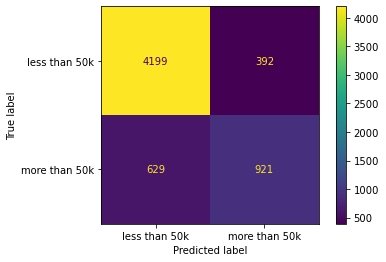

In [69]:
from sklearn.metrics import plot_confusion_matrix
x_test_prepared = full_pipeline.transform(x_test)
plot_confusion_matrix(clf_knn, X_test_prepared, y_test, values_format='d', 
                      display_labels=['less than 50k','more than 50k'])

This model did not do a particularly good job so I will test support vector machines to potentially generate a more accurate model.

## SVM

In [114]:
from sklearn.svm import SVC

SVMs do better with smaller data so I will resample the original dataset with an equal number of rows from each outcome of the income prediction.

In [115]:
# need to downsample since SVC cannot handle large datasets
# 1000 rows for <=50K and 1000 rows for >50K

df_more = adult_df[adult_df.income==1]
df_less = adult_df[adult_df.income==0]

from sklearn.utils import resample
df_less_downsampled = resample(df_less, replace=False, n_samples=2000, random_state=42)
df_more_downsampled = resample(df_more, replace=False, n_samples=2000, random_state=42)
df_downsampled = pd.concat([df_less_downsampled, df_more_downsampled])

As before, I will perform stratification of the train-test data split for the occupation feature. Then, I will scale numeric data and one-hot-encode categorical data.

In [116]:
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2)
for train_index, test_index in split.split(df_downsampled,df_downsampled['occupation']):
    train_idx = df_downsampled.index[train_index]
    test_idx = df_downsampled.index[test_index]
    strat_train_set = df_downsampled.loc[train_idx]
    strat_test_set = df_downsampled.loc[test_idx]
    
y_train = strat_train_set['income']
y_test = strat_test_set['income']
X_train = strat_train_set.drop(columns='income')
X_test = strat_test_set.drop(columns='income')

In [117]:
num_features = ['age','fnlwgt','education.num','hours.per.week']
# include native.country below if not converting to domestic/foreign
cat_features = ['workclass','education','marital.status','occupation','race','capital.gain']

full_pipeline = ColumnTransformer([
    ("num", StandardScaler(), num_features), 
    ("cat", OneHotEncoder(), cat_features),
])

X_train_prepared = full_pipeline.fit_transform(X_train)

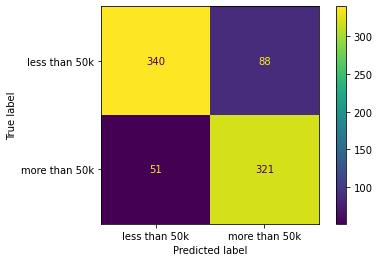

In [128]:
clf_svm = SVC()
clf_svm.fit(X_train_prepared,y_train)

from sklearn.metrics import plot_confusion_matrix
X_test_prepared = full_pipeline.transform(X_test)
plot_confusion_matrix(clf_svm, X_test_prepared, y_test, values_format='d', display_labels=['less than 50k','more than 50k'])

Wow! This model already improves significantly over the KNN model.  I will see if a grid search with cross-validation will improve the model further.

In [119]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'C': [0.5, 1, 10, 100], 
     'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001], 
     'kernel': ['rbf']},
]

clf_svm = SVC()
grid_search = GridSearchCV(clf_svm, param_grid, cv=5, scoring='accuracy',
                           return_train_score=True) 
grid_search.fit(X_train_prepared, y_train)
grid_search.best_params_

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

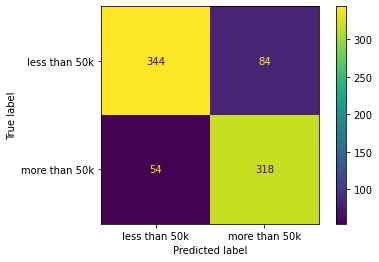

In [122]:
clf_svm = SVC(C=100, gamma=0.01, kernel='rbf')
clf_svm.fit(X_train_prepared,y_train)
plot_confusion_matrix(clf_svm, X_test_prepared, y_test, values_format='d', display_labels=['less than 50k','more than 50k'])

The grid search did not affect accuracy much.  However, overall the model makes accurate decisions with a high precision and recall according to the classification report below.  

In [123]:
y_train_pred = cross_val_predict(clf_svm, X_train_prepared, y_train, cv=10)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.84      0.77      0.80      1572
           1       0.79      0.86      0.82      1628

    accuracy                           0.81      3200
   macro avg       0.81      0.81      0.81      3200
weighted avg       0.81      0.81      0.81      3200



Now, let's see how the model performs on the entire dataset.

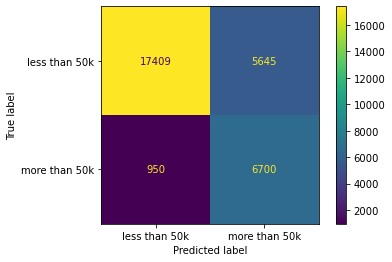

In [135]:
X = adult_df.drop(columns='income')
X_prepared = full_pipeline.transform(X)
y = adult_df.income
plot_confusion_matrix(clf_svm, X_prepared, y, values_format='d', display_labels=['less than 50k','more than 50k'])

This resulted in very high precision and recall! Although there is some training data in here that could skew the results, the overwhelming majority of the data was not used to train the model.  In my first data science project, I further developed my skills in data science to properly clean data and fit an optimal model to make accurate predictions. 